In [47]:
!pip install wget
import wget
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [19]:
if not os.path.isdir("data/DogBreeds"):
    wget.download("https://oshi.at/oSjpZL", bar=wget.bar_adaptive)

    import zipfile
    with zipfile.ZipFile("iykm.zip", "r") as zip_ref:
        zip_ref.extractall("")


train_path = 'data/DogBreeds/train'
valid_path = 'data/DogBreeds/test'

In [20]:
image_size = 299
batch_size = 10

classes = os.listdir(train_path)

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input) \
    .flow_from_directory(directory=train_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input) \
    .flow_from_directory(directory=valid_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size)

Found 9000 images belonging to 120 classes.
Found 1200 images belonging to 120 classes.


Wir verwenden nun das VGG16 Modell für Transfer Learning.
Unser Ziel ist es, ein neuronales Netz zu erstellen, welches Bilder von Katzen und Hunden unterscheiden kann. Dies geht mit einfachen CNNs nicht so gut, deshalb versuchen wir es mit Transfer Learning bei einem bereits trainierten neuronalen Netz, welches wir auf unsere Bedürfnisse spezialisieren.

Wir erstellen nun ein eigenes Modell, das die gleichen Ebenen wie VGG16 hat außer der letzten.

Da wir die Ebenen vor unserer Spezialisierung (dem letzten voll vernetzen neuronalen Netz) nicht erneut trainieren wollen, werden wir diese freezen, d. h. `trainable = False` setzen.

Statt dem Dense Layer mit 1000 Outputs verwenden wir ein Dense Layer mit 2 Outputs - Katze oder Hund.

In [51]:
xception_no_top = tf.keras.applications.Xception(include_top=False, input_shape=(299, 299, 3))
x = xception_no_top.layers[-1].output
flat = Flatten()(x)
output = Dense(units=len(classes), activation='softmax')(flat)

model = Model(inputs=xception_no_top.input, outputs=output)
for layer in model.layers[:-10]:
    layer.trainable = False
model.summary(line_length=200)

Model: "model_8"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input_17 (InputLayer)                                             [(None, 299, 299, 3)]                       0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
block1_conv1 (Conv2D)                                             (None, 149, 149, 32)                        864                     input_17[0][0]                               

Nun haben wir ein Modell, welches nur 8194 anpassbare Parameter hat statt 134 Millionen.
Wir verwenden wieder `Adam` als Optimizer und categorical crossentropy loss als loss funktion.

In [52]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=3, verbose=2)

Epoch 1/3
900/900 - 4463s - loss: 1.3128 - accuracy: 0.7170 - val_loss: 1.4930 - val_accuracy: 0.7733
Epoch 2/3
900/900 - 4440s - loss: 0.2335 - accuracy: 0.9337 - val_loss: 1.3646 - val_accuracy: 0.7892
Epoch 3/3
900/900 - 4444s - loss: 0.1308 - accuracy: 0.9628 - val_loss: 1.3019 - val_accuracy: 0.8050


Nun betrachten wir wieder das Test-Set.

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, classes, title='Konfusionsmatrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() * 2. / 3
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Tatsächlich')
    plt.xlabel('Vorhersage')

In [ ]:
predictions = model.predict(x=test_batches, verbose=2)

10/10 - 51s


In [ ]:
import numpy as np
preds = np.argmax(predictions, axis=1)
print("Predictions:\n", preds)
print("Actual:\n", test_batches.classes)
print("Accuracy:", sum(preds == test_batches.classes)/preds.shape[0])

Predictions:
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy: 0.94


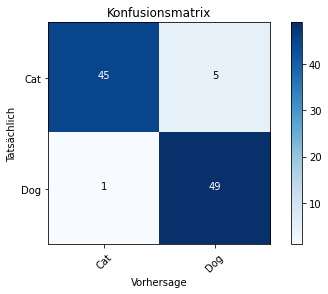

In [ ]:
plot_cm(test_batches.classes, preds, classes)